# Random Forest Model - Disease Prediction

## Configure Environment

In [1]:
##-- Core Libraries
import pandas as pd
import numpy as np

##-- Visualization
import matplotlib.pyplot as plt
import seaborn as sns

##-- Machine Learning
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

import torch
import tensorflow

##-- Utilities
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Data Preprocessing

In [2]:
dtype_dict_1 = {
    'RowID': 'int64',
    'PersonID': 'int64',
    'Gender': 'int',
    'LivingSituation': 'int64',
    'State': 'int64',
    'Smoker': 'int',
    'Height': 'float64',
    'Weight': 'float64',
    'Disease1': 'int64',
    'Disease1Severity': 'int64',
    'NextDisease': 'int64',
}

dtype_dict_2 = {
    'Disease2': 'int64',
    'Disease3': 'int64',
    'Disease2Severity': 'int64',
    'Disease3Severity': 'int64',
}

In [3]:
##-- Load data
df = pd.read_csv('pv_datascience_takehome_data.csv',dtype=dtype_dict_1)

##-- Convert date columns to datetime
df['EvaluationDate'] = pd.to_datetime(df['EvaluationDate'])
df['DOB'] = pd.to_datetime(df['DOB'])
df['Age'] = df['EvaluationDate'].dt.year - df['DOB'].dt.year

##-- Calculate age at evaluation
df['Age'] = df['Age'].astype('float')
df['NextDisease'] = df['NextDisease'].astype('str')

##-- Drop non-feature columns
df = df.drop(['RowID', 'PersonID', 'EvaluationDate', 'DOB', 'NextDiseaseDiagnosisDate'], axis=1)

##-- Fill NaN values with median
df.fillna(df[['Height','Weight','Age']].median(), inplace=True)
df = df.dropna()

##-- Assign datatypes
df = df.astype(dtype_dict_2)

In [4]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 9998 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Gender            9998 non-null   int64  
 1   LivingSituation   9998 non-null   int64  
 2   State             9998 non-null   int64  
 3   Smoker            9998 non-null   int64  
 4   Height            9998 non-null   float64
 5   Weight            9998 non-null   float64
 6   Disease1          9998 non-null   int64  
 7   Disease2          9998 non-null   int64  
 8   Disease3          9998 non-null   int64  
 9   Disease1Severity  9998 non-null   int64  
 10  Disease2Severity  9998 non-null   int64  
 11  Disease3Severity  9998 non-null   int64  
 12  NextDisease       9998 non-null   object 
 13  Age               9998 non-null   float64
dtypes: float64(3), int64(10), object(1)
memory usage: 1.1+ MB


,Gender,LivingSituation,State,Smoker,Height,Weight,Disease1,Disease2,Disease3,Disease1Severity,Disease2Severity,Disease3Severity,Age
count,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000
mean,0.625725,0.817463,26.420084,0.038708,0.423687,0.216499,469.023105,442.698040,442.555311,1.278356,1.260052,1.115323,79.524605
std,0.483959,0.410899,18.655899,0.192907,0.071472,0.071486,115.172755,126.277088,134.408896,1.430751,1.189290,1.083954,6.508860
min,0.000000,0.000000,1.000000,0.000000,0.142857,0.003899,251.000000,251.000000,251.000000,-1.000000,-1.000000,-1.000000,45.000000
25%,0.000000,1.000000,8.000000,0.000000,0.375000,0.167641,382.000000,336.000000,336.000000,0.000000,0.000000,0.000000,75.000000
50%,1.000000,1.000000,21.000000,0.000000,0.428571,0.214425,470.000000,406.000000,398.000000,2.000000,1.000000,1.000000,79.000000
75%,1.000000,1.000000,43.000000,0.000000,0.482143,0.257310,592.000000,541.000000,570.000000,2.000000,2.000000,2.000000,84.000000
max,1.000000,2.000000,68.000000,1.000000,0.660714,0.760234,693.000000,693.000000,693.000000,4.000000,4.000000,4.000000,100.000000


In [5]:
##-- Value counts for each unique class in 'NextDisease' column
counts = df['NextDisease'].value_counts()

##-- Identify diseases that appear only 1x in the dataset
to_remove = counts[counts == 1].index

##-- Remove rows where 'NextDisease' is one of the diseases that appear only once
df = df[~df['NextDisease'].isin(to_remove)]

In [6]:
##-- Specify the target
y = df['NextDisease']
##-- Specify the features
X = df

In [7]:
def custom_train_test_split(X, y, feature_col, test_size=0.2):
    unique_feature_values = X[feature_col].unique()
    unique_target_values = y.unique()
    
    X_train, X_test, y_train, y_test = [], [], [], []
    
    for feature_value in unique_feature_values:
        for target_value in unique_target_values:
            subset = X[(X[feature_col] == feature_value) & (y == target_value)]
            subset_y = y[(X[feature_col] == feature_value) & (y == target_value)]
            
            if len(subset) == 0:
                continue
                
            X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(subset, subset_y, test_size=test_size)
            
            X_train.append(X_train_sub)
            X_test.append(X_test_sub)
            y_train.append(y_train_sub)
            y_test.append(y_test_sub)
            
    X_train = pd.concat(X_train) 
    X_test = pd.concat(X_test) 
    y_train = pd.concat(y_train)
    y_test = pd.concat(y_test)
    
    return X_train, X_test, y_train, y_test

##-- Drop overlapping column & split data evenly
feature_col = 'NextDisease'
X_train, X_test, y_train, y_test = custom_train_test_split(X, y, feature_col)

In [8]:
X_train.drop('NextDisease', axis=1, inplace=True)
X_test.drop('NextDisease', axis=1, inplace=True)

## Random Forest Model

In [9]:
rfc = RandomForestClassifier(class_weight='balanced')
# rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

$$
\text{Class weight} = \frac{\text{Total samples}}{\text{Number of classes} \times \text{Number of samples in the class}}
$$

In [10]:
##-- Check n columns in y_prob
y_prob = rfc.predict_proba(X_test)
y_pred = rfc.predict(X_test)

##-- Check n unique classes in y_test
n_unique_classes = len(np.unique(y_test))

##-- Check n features in y_prob and y_pred
n_columns_y_prob = y_prob.shape[1]
n_columns_y_pred = y_pred.shape[0]

##-- Check if y_test & y_prob match in size
if n_unique_classes != n_columns_y_prob:
    print(f"n classes in y_test ({n_unique_classes}) != n of columns in y_prob ({n_columns_y_prob})")
else:

    ##-- AUC-ROC
    roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr',average='weighted')
    print("AUC-ROC:", roc_auc)

    ##-- F1 Score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("F1 Score:", f1)

AUC-ROC: 0.5992351718727738
F1 Score: 0.04355954959585743


## Results

**Overall, the model's performance needs improvement:**
* AUC-ROC value of 0.599 suggests the model has limited ability to distinguish between classes, slightly better than random chance (0.5)
* F1 score of 0.044 is very low, indicating poor precision and recall

**How to improve the model?**

Steps *that could be done* to improve the model:

* Hyperparameter Tuning
    * Use GridSearchCV or RandomizedSearchCV
* Ensemble Methods
    * Use techniques like bagging or boosting
* Cross-Validation
    * Use stratified k-fold for better generalization
* Regularization
    * Helps to avoid overfitting (e.g. using LASSO)
* Feature Engineering
    * Add or transform features (e.g. normalize if not already done)
* Different Algorithm
    * Test other ML models

Steps *already done* to improve the model:

* Update Data &rarr; More data can help the model generalize better  
    * Data volume is already sufficient
* Class Imbalance &rarr; 
    * Use resampling techniques or adjust class weights &rarr; Utilized 'weighted' average
* Evaluate Metrics &rarr; Consider other metrics like Precision, Recall 
    * F1 score encompasses these metrics
* Data Cleaning &rarr; Handle missing or outlier values 
    * Checked data distributions - distributions for each feature do not appear to be highly skewed

## Data Visualization

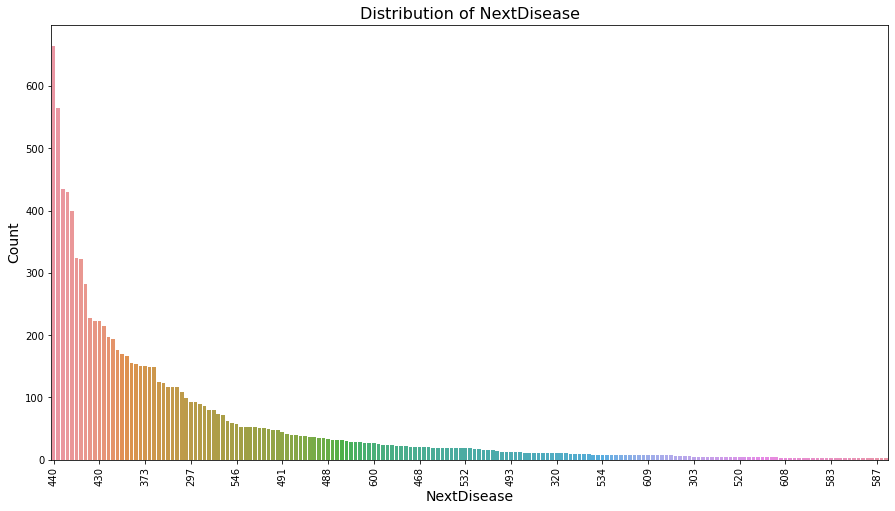

In [40]:
y_col = "NextDisease"
plt.figure(figsize=(15, 8))
sns.countplot(data=y, x=y, order=y.value_counts().index)
# plt.xticks(rotation=90)
plt.xticks(ticks=range(0, len(y.unique()), 10), rotation=90)
plt.xlabel(f'{y_col}', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title(f'Distribution of {y_col}', fontsize=16)
plt.show()

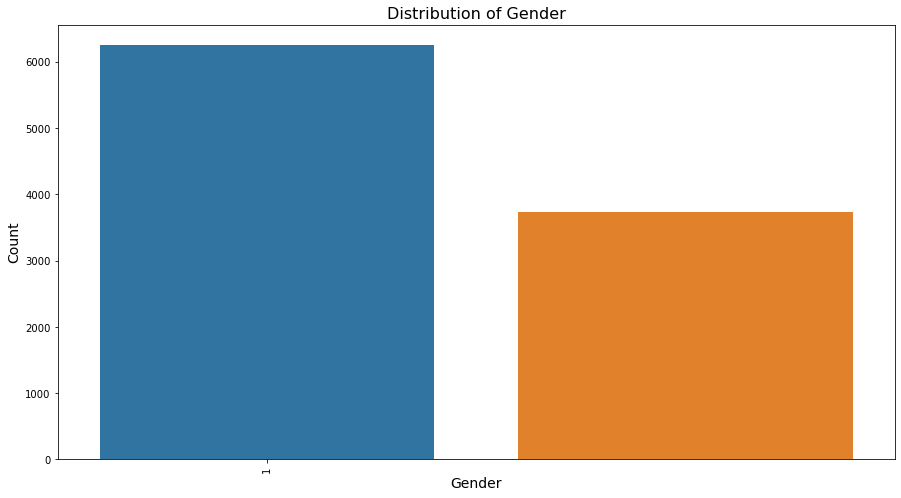

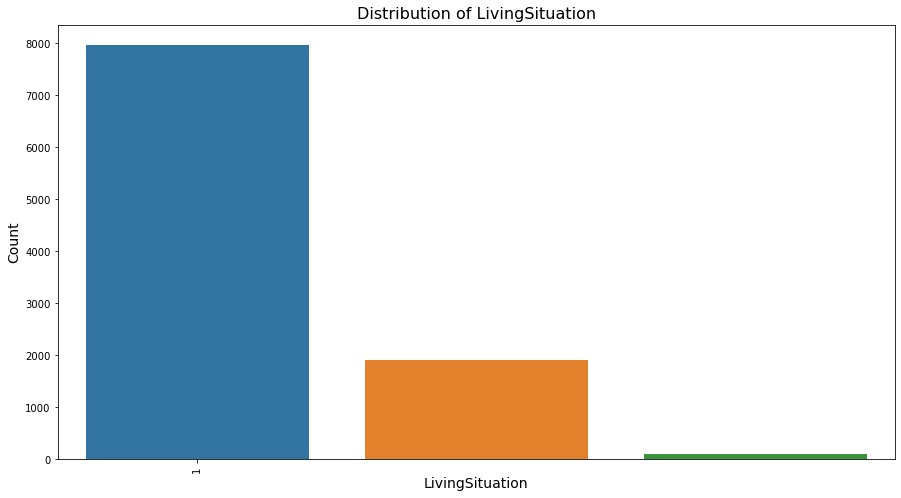

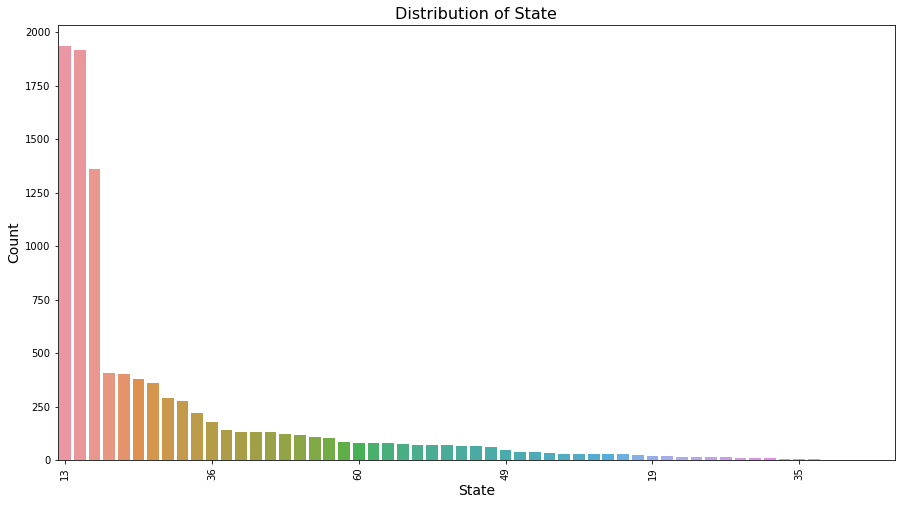

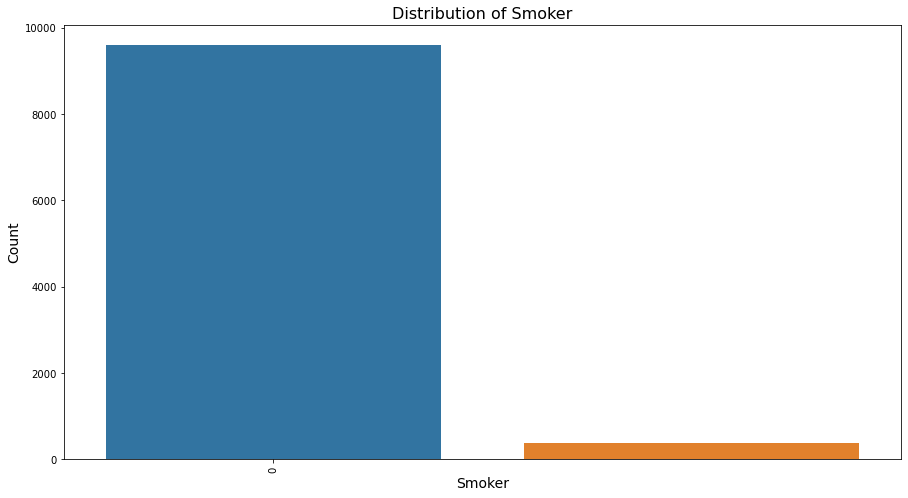

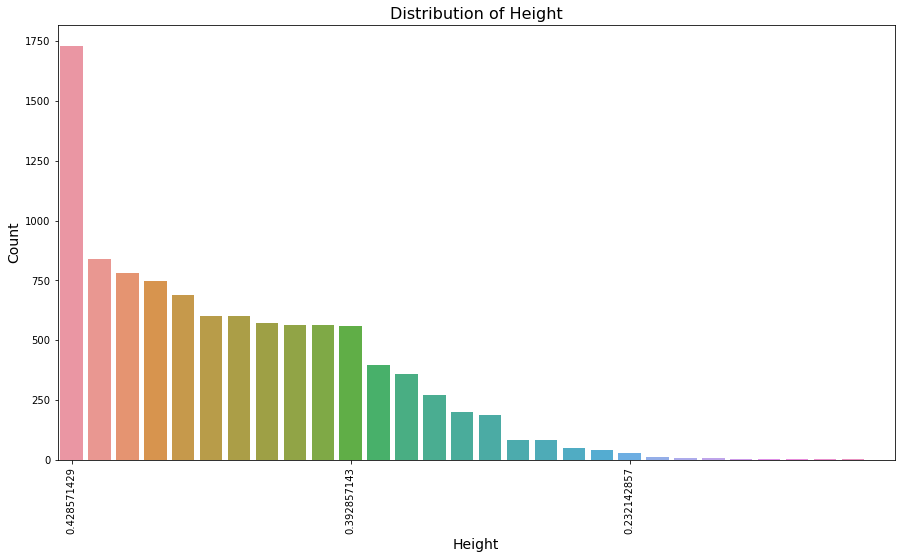

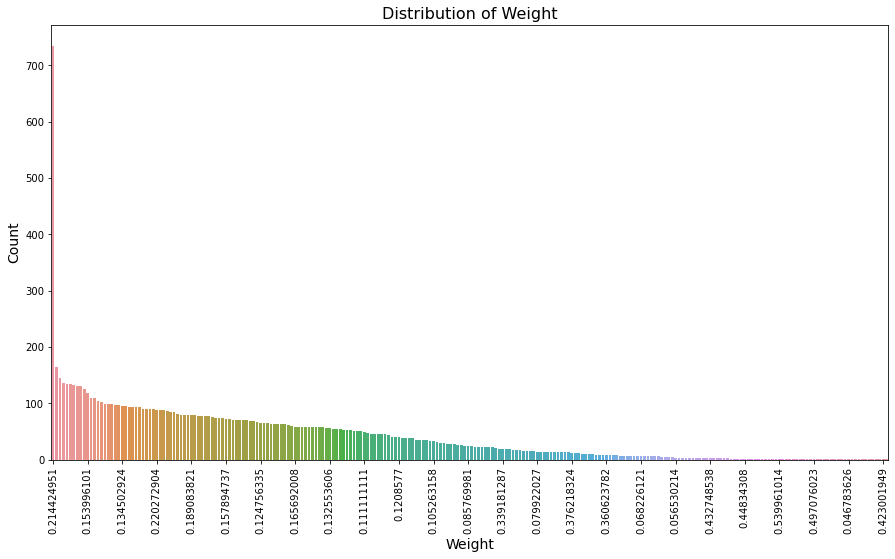

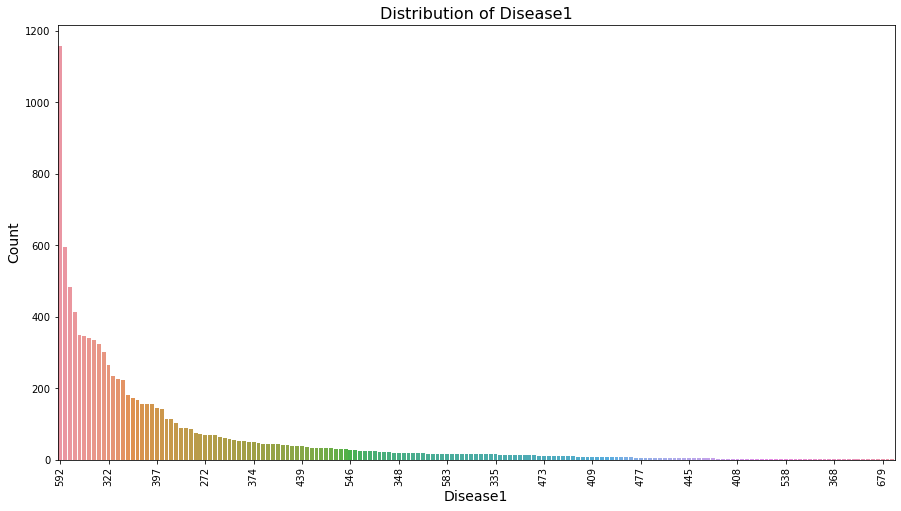

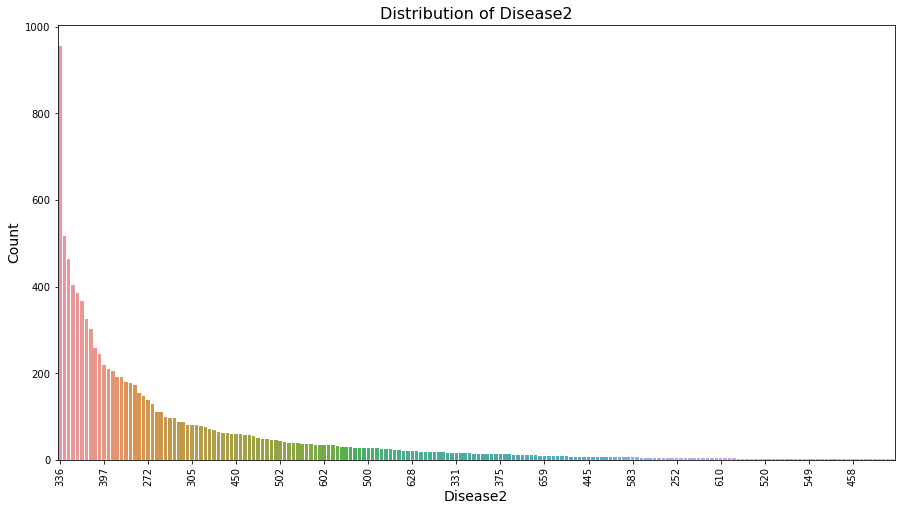

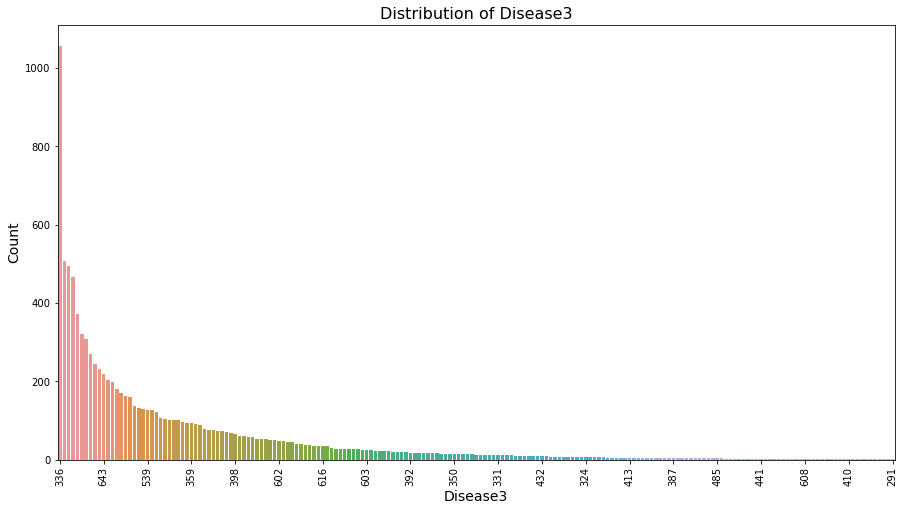

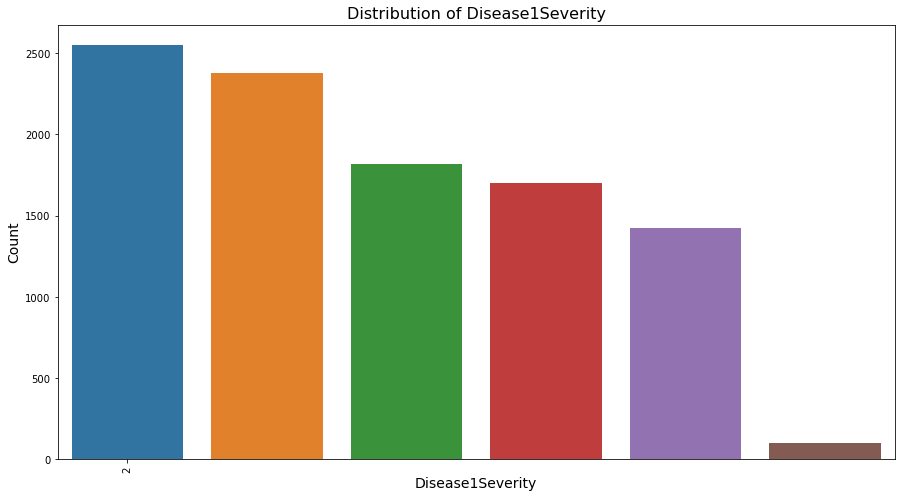

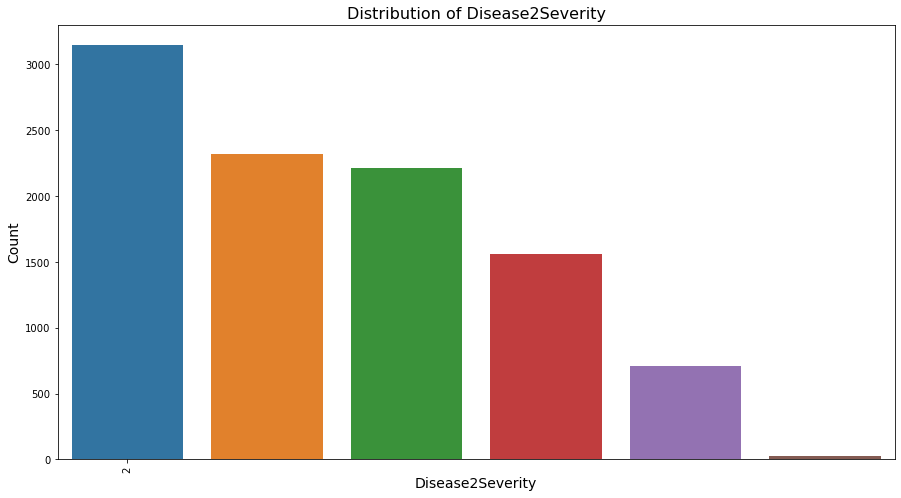

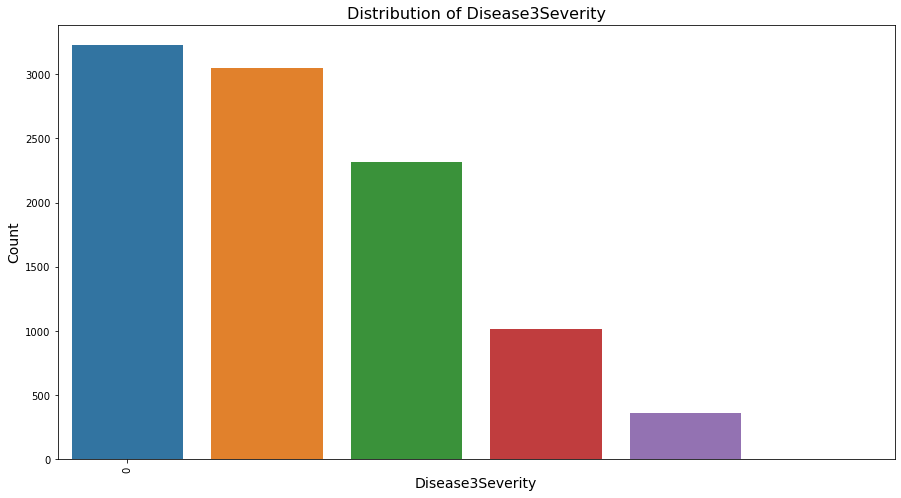

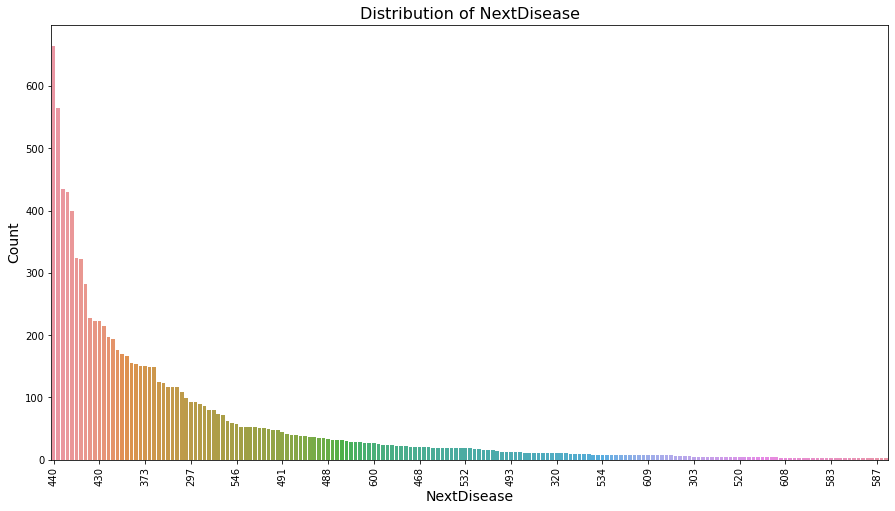

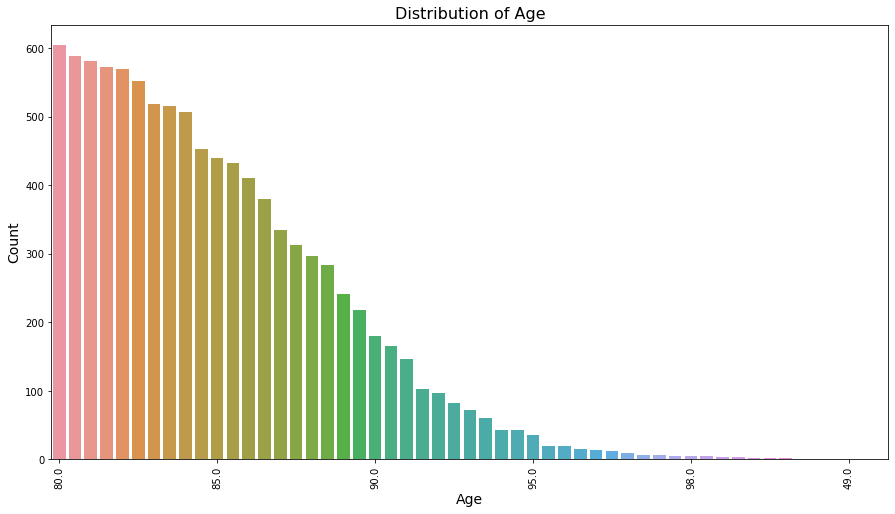

In [39]:
def plot_fig(X,column):
    plt.figure(figsize=(15, 8))
    # sns.countplot(data=df, x='NextDisease', order=df['NextDisease'].value_counts().index)
    sns.countplot(data=X, x=f'{column}', order=X[f'{column}'].value_counts().index)

    # plt.xticks(ticks=range(0, len(df[f'{column}'].unique()), 10), rotation=90)
    plt.xticks(ticks=range(0, len(X[f'{column}'].unique()), 10), rotation=90)

    plt.xlabel(f'{column}', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.title(f'Distribution of {column}', fontsize=16)
    plt.show()
    return

for column in X.columns:
    plot_fig(X,column)